In [42]:
import numpy as np
N=500

mat = np.zeros((N,N))
for i in range(N-1):
    mat[i, i+1] = 1
    mat[i+1, i] = 1

print(mat)
print(np.linalg.eig(mat)[0])

def normalize(sigma):
    dim = sigma.shape[0]
    # Impose PD and mean of eigenvalues equal 1

    # Forces all diagonal elements to be the same
    # That's the easiest way to ensure all ev > 0...
    sigma -= np.diag(np.diag(sigma))
    sigma += np.diag([dim for _ in range(dim)])

    sigma *= dim / np.sum(np.linalg.eig(sigma)[0])
    assert np.all(np.linalg.eig(sigma)[0] > 0.)
    assert np.abs(np.sum(np.linalg.eig(sigma)[0]) - dim) < 0.05

    return sigma

mat2 = normalize(mat)
print(mat2)
print(np.sort(np.linalg.eig(mat2)[0]))

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
[-1.99996068 -1.99984272 -1.99964612 -1.9993709  -1.99901706 -1.99858461
 -1.99807358 -1.99748399 -1.99681585 -1.99606919 -1.99524405 -1.99434045
 -1.99335843 -1.99229804 -1.9911593  -1.98994227 -1.98864699 -1.98268449
 -1.98429221 -1.98727352 -1.98582191 -1.98099881 -1.97923523 -1.97739383
 -1.97547468 -1.97347785 -1.97140342 -1.96925147 -1.96702209 -1.96471536
 -1.96233138 -1.95987024 -1.95733204 -1.95471687 -1.95202484 -1.94925606
  1.99996068  1.99984272  1.99964612  1.9993709   1.99901706  1.99858461
  1.99807358  1.99748399  1.99681585  1.99606919  1.99524405  1.99434045
  1.99335843  1.99229804  1.9911593   1.98994227  1.98864699  1.98727352
  1.98582191  1.98429221  1.98268449  1.98099881  1.97923523  1.97739383
  1.97547468  1.97347785 -1.94641063 -1.94348866 -1.94049028 -1.93741559
 -0.96724176 -0.97819978 -0.98911934 -1. 

(1, 50)
(200, 50)
0.9600758668505169 1.0399241331494822
after clipping 0.9600758668505169 1.0399241331494822


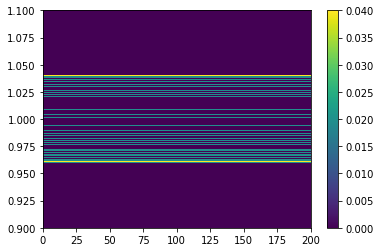

In [38]:
import matplotlib.pyplot as plt
N = 50

plop = np.reshape(np.linalg.eig(mat2)[0], (1, N))
print(plop.shape)
plop = np.repeat(plop, 200, axis=0)
print(plop.shape)

n_bins = 300
grouping = 10
v_min, v_max = 0.9, 1.1

print(np.min(plop), np.max(plop))
mixed_evs = np.clip(plop, v_min, v_max)
print('after clipping', np.min(mixed_evs), np.max(mixed_evs))
# print(np.sum(mixed_evs == 0), np.sum(mixed_evs == 1.5))
bounds = [v_min, v_max]
diff_map = np.zeros((plop.shape[0] // grouping, n_bins))
for t in range(plop.shape[0]):
    for ev in mixed_evs[t]:
        diff_map[t // grouping-1, int((n_bins-1) * (ev-bounds[0]) / (bounds[1] - bounds[0]))] += 1.
        # print(int((n_bins-1) * (ev-bounds[0]) / (bounds[1] - bounds[0])))

for t in range(diff_map.shape[0]):
    diff_map[t] /= np.sum(diff_map[t])

# print(np.sum(diff_map, axis=1))
# print(diff_map[0])
# print(diff_map[-1])


plt.figure()
plt.imshow(diff_map.T, extent=[0, plop.shape[0], bounds[0], bounds[1]], aspect='auto')
plt.colorbar()

In [54]:
import numpy as np

N = 50
def generate_pd_matrix(dim):
    sigma = np.random.normal(np.zeros([dim,dim], dtype=np.float32), 1./np.sqrt(dim))
    sigma = (sigma + sigma.T) / np.sqrt(2)
    return sigma


def normalize(sigma):
    dim = sigma.shape[0]
    # Impose PD and diagonal of inverse equal to 1

    # Forces all diagonal elements to be the same
    # That's the easiest way to ensure all ev > 0...
    sigma -= np.diag(np.diag(sigma))
    sigma += np.diag([dim for _ in range(dim)])

    sigma *= dim / np.sum(np.linalg.eig(sigma)[0])
    assert np.all(np.linalg.eig(sigma)[0] > 0.)
    assert np.all(np.diag(np.linalg.inv(sigma)) - np.diag(np.linalg.inv(sigma))[0] < 1e-8)
    sigma *= np.diag(np.linalg.inv(sigma))[0]
    assert np.all(np.abs(np.diag(np.linalg.inv(sigma)) - 1) < 1e-8)

    return sigma


class CenteredGM:
    def __init__(self, dim, sigma=None):
        self.dim = dim
        if sigma is not None:
            self.sigma = normalize(sigma)
        else:
            self.sigma = normalize(generate_pd_matrix(self.dim))

        # Sanity checks before model build
        # print(np.linalg.eig(self.sigma)[0])
        assert np.all(np.linalg.eig(self.sigma)[0] > 0.)
        assert self.sigma.shape == (self.dim, self.dim)
        assert np.max(np.abs(self.sigma-self.sigma.T)) < 10**(-6)
        # assert np.max(np.abs(np.diag(self.sigma))) < 10**(-6)
#         print('eigenvalues : ', np.sort(np.linalg.eig(self.sigma)[0]))
#         print('diagonal of inverse : ', np.diag(np.linalg.inv(self.sigma)))

    def sample(self, n_samples):
        return np.random.multivariate_normal(mean=np.zeros(self.dim), cov=self.sigma, size=int(n_samples))

    def get_empirical_C(self, n_samples):
        obs = self.sample(n_samples)
        assert obs.shape == (n_samples, self.dim)
        assert np.dot(obs.T, obs).shape == (self.dim, self.dim)
        return np.dot(obs.T, obs) / n_samples


sigma = np.zeros((N, N))
sigma[0, N-1] = 1
sigma[N-1, 0] = 1

for i in range(N - 1):
    sigma[i, i + 1] = 1
    sigma[i + 1, i] = 1
model_to_fit = CenteredGM(N, sigma=sigma)

eigenvalues :  [0.96076892 0.96108459 0.96108459 0.9620266  0.9620266  0.96358011
 0.96358011 0.96572062 0.96572062 0.96841436 0.96841436 0.97161886
 0.97161886 0.97528358 0.97528358 0.97935072 0.97935072 0.98375615
 0.98375615 0.98843038 0.98843038 0.99329971 0.99329971 0.99828733
 0.99828733 1.00331459 1.00331459 1.00830222 1.00830222 1.01317154
 1.01317154 1.01784577 1.01784577 1.0222512  1.0222512  1.02631834
 1.02631834 1.02998306 1.02998306 1.03318756 1.03318756 1.0358813
 1.0358813  1.03802181 1.03802181 1.03957532 1.03957532 1.04051734
 1.04051734 1.040833  ]
diagonal of inverse :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
